# Tutorial notebook 6: Cell Type Annotation with C2S Foundation Model

In this tutorial notebook, we demonstrate how to do cell type prediction on single-cell datasets using C2S models without having to finetune your own C2S model. We will do this by utilizing the C2S-Pythia-410M cell type prediction foundation model, which is a pretrained C2S model which was trained to do cell type prediction across many datasets. We will examine annotating cells in our dataset through the lens of this cell type annotation C2S model.

This notebook will:
1. Load an immune tissue single-cell dataset from Domínguez Conde et al. (preprocessed in tutorial notebook 0, two sample donors)
    - Citation: Domínguez Conde, C., et al. "Cross-tissue immune cell analysis reveals tissue-specific features in humans." Science 376.6594 (2022): eabl5197.
2. Load a C2S model which was pretrained to do cell type annotation on many datasets
3. Annotate a subset of cells in the single-cell dataset using the C2S model

Let's get started!

We will begin by importing the necessary libraries. These include Python's built-in libraries, third-party libraries for handling numerical computations, progress tracking, and specific libraries for single-cell RNA sequencing data and C2S operations.

In [1]:
# Python built-in libraries
import os
import pickle
import random
from collections import Counter

# Third-party libraries
import numpy as np
from tqdm import tqdm

# Single-cell libraries
import anndata
import scanpy as sc

# Cell2Sentence imports
import cell2sentence as cs
from cell2sentence.tasks import predict_cell_types_of_data

/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Load Data

Next, we will load the preprocessed dataset from the tutorial 0. This dataset has already been filtered and normalized, so it it ready for transformation into cell sentences.

<font color='red'>Please make sure you have completed the preprocessing steps in Tutorial 0 before running the following code, if you are using your own dataset.</font>. Ensure that the file path is correctly set in <font color='gold'>DATA_PATH</font> to where your preprocessed data was saved from tutorial 0.

In [3]:
DATA_PATH = "/home/sr2464/palmer_scratch/C2S_Files_Syed/Cell2Sentence_Datasets/dominguez_conde_immune_tissue_two_donors_preprocessed_tutorial_0.h5ad"

In [4]:
adata = anndata.read_h5ad(DATA_PATH)
adata

AnnData object with n_obs × n_vars = 29773 × 23944
    obs: 'cell_type', 'tissue', 'batch_condition', 'organism', 'assay', 'sex', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_name', 'ensembl_id', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'batch_condition_colors', 'cell_type_colors', 'log1p', 'neighbors', 'pca', 'tissue_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
adata.obs = adata.obs[["cell_type", "tissue", "batch_condition", "organism", "sex"]]

In [6]:
adata.obs.head()

,cell_type,tissue,batch_condition,organism,sex
Pan_T7935490_AAACCTGCAAATTGCC,CD4-positive helper T cell,ileum,A29,Homo sapiens,female
Pan_T7935490_AAACGGGCATCTGGTA,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAACGGGTCTTGCATT,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAAGCAATCATCGCTC,"CD8-positive, alpha-beta memory T cell",ileum,A29,Homo sapiens,female
Pan_T7935490_AAAGTAGCAGTCACTA,gamma-delta T cell,ileum,A29,Homo sapiens,female


In [7]:
adata.var.head()

,gene_name,ensembl_id,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
RP11-34P13,RP11-34P13,ENSG00000238009,38,False,38,0.001310,99.872368,39.0
RP11-34P13-3,RP11-34P13,ENSG00000241860,106,False,106,0.003627,99.643973,108.0
AP006222,AP006222,ENSG00000286448,7,False,7,0.000235,99.976489,7.0
LINC01409,LINC01409,ENSG00000237491,1292,False,1292,0.045981,95.660498,1369.0
FAM87B,FAM87B,ENSG00000177757,3,False,3,0.000101,99.989924,3.0


/vast/palmer/home.mccleary/sr2464/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


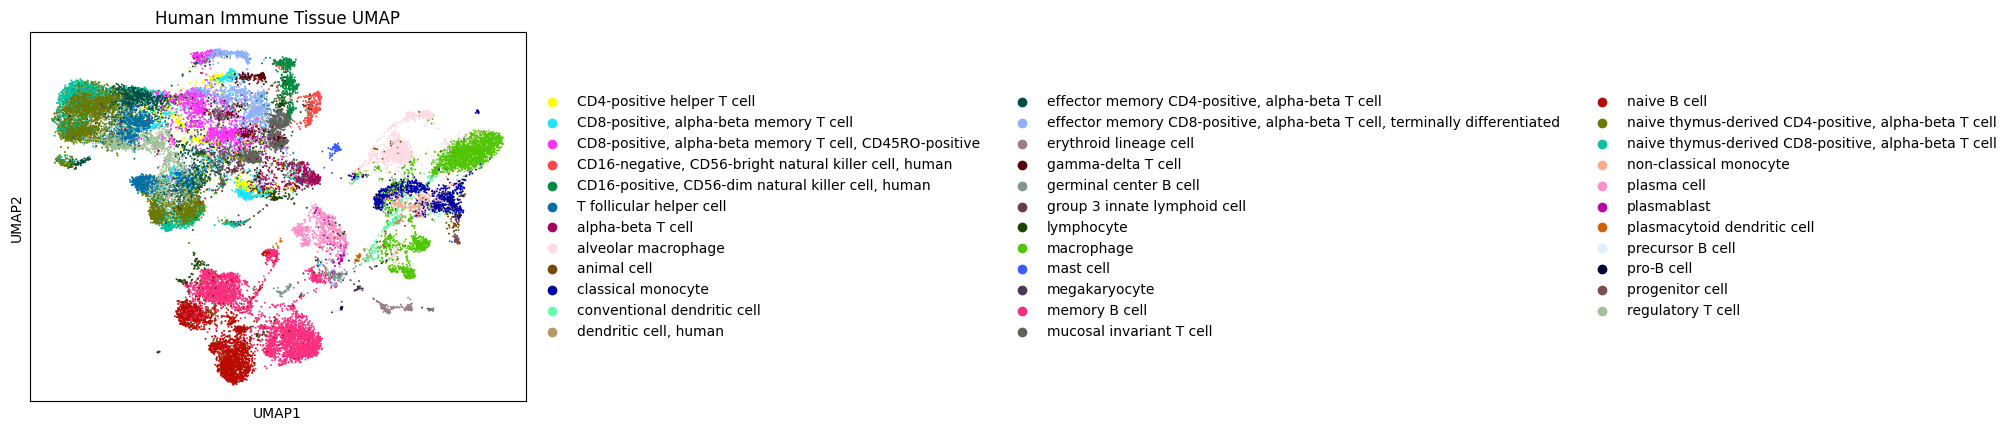

In [8]:
sc.pl.umap(
    adata,
    color="cell_type",
    size=8,
    title="Human Immune Tissue UMAP",
)

In [9]:
adata.X.max()

3.408124

We are expecting log10 base 10 transformed data, with a maximum value somewhere around 3 or 4. Make sure to start with processed and normalized data when doing the cell sentence conversion!

# Cell2Sentence Conversion

In this section, we will transform our AnnData object containing our single-cell dataset into a Cell2Sentence (C2S) dataset by calling the functions of the CSData class in the C2S code base. Full documentation for the functions of the CSData class can be found in the documentation page of C2S.

In [10]:
adata_obs_cols_to_keep = adata.obs.columns.tolist()
adata_obs_cols_to_keep

['cell_type', 'tissue', 'batch_condition', 'organism', 'sex']

In [11]:
# Create CSData object
arrow_ds, vocabulary = cs.CSData.adata_to_arrow(
    adata=adata, 
    random_state=SEED, 
    sentence_delimiter=' ',
    label_col_names=adata_obs_cols_to_keep
)

100%|██████████| 29773/29773 [00:11<00:00, 2579.82it/s]


In [12]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'],
    num_rows: 29773
})

In [13]:
sample_idx = 0
arrow_ds[sample_idx]

{'cell_name': 'Pan_T7935490_AAACCTGCAAATTGCC',
 'cell_sentence': 'RPLP1 ACTB EEF1A1 HSP90AA1 TMSB4X B2M FTH1 KLF6 HSPA1B MALAT1 RPS12 HSPA8 RPL13 MT-CO1 ATF3 MT-CO2 RPL41 TPT1 MT-CO3 RPS19 HLA-B RPL10 RPS4X RPL28 MT-CYB DUSP1 RPL30 MT-ND4L RPS15 FOS RPL34 RPS2 RPLP2 MT-ND3 RPS18 RPS8 TRBV7-2 RPL32 RPS3 ANXA1 RPL11 HLA-C RPS27 ACTG1 UBC RPL3 RPL37 RPLP0 MT-ATP6 JUNB RPS28 RPL18 UBB MT-ATP8 RPS14 RPL39 PFN1 GAPDH HSPA1A RPL18A SRGN RPS27A RPL26 RPL19 RPS15A HLA-A DNAJB1 RPS3A CREM RPS13 MT-ND1 RPL21 RPS25 BTG2 RPL35A FAU RPL8 RPL7A RPS24 RPS6 RPS16 RACK1 NFKBIA RGS1 RPL29 CALM1 RPL9 RPL37A MT-ND5 TNFAIP3 RPS23 IL7R RPL36A PTMA NFKBIZ UBA52 EIF1 CRIP1 CORO1A RPL14 HSP90AB1 RPL10A CXCR4 RPL4 EEF1B2 RPL36 RPS9 RPL27 NACA VIM H3-3B RPS7 HSPH1 ATP5F1E HLA-E RPL17 RPSA MYL12A RPL12 CD69 TAGAP RPL35 RPS29 RPL6 SARAF ZFP36L2 MT-ND4 ARHGDIB BTG1 RPS21 EEF1D PNRC1 EEF1G HSPA5 FYB1 CD3E IFITM1 RNASEK EEF2 MT-ND2 FTL S100A4 JUN IFITM2 CYTIP OST4 LAPTM5 RPL36AL PLAAT4 PFDN5 SAMSN1 DNAJA1 EIF4A1 FXYD5

This time, we will leave off creating our CSData object until after we load our C2S model. This is because along with the model checkpoint, we saved the indices of train, val, and test set cells, which will allow us to select out test set cells for inference.

# Load C2S Model

Now, we will load a C2S model with which we will do cell type annotation. For this tutorial, this model will be the C2S-Pythia-410M cell type prediction foundation model, which has already been trained to do cell type annotation on a diverse set of single-cell datasets from CellxGene and Human Cell Atlas. More details about this model can be found in the Model Zoo section of the GitHub ReadME, or in the Huggingface page of the C2S-Pythia model.

We can define our CSModel object with our pretrained cell type prediction model as follows:

In [14]:
# Define CSModel object
cell_type_prediction_model_path = "/home/sr2464/palmer_scratch/C2S_Files_Syed/multicell_pretraining_v2_important_models/pythia-410m-multicell_v2_2024-07-28_13-55-51_checkpoint-7600_cell_type_pred"
save_dir = "/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/csmodel_tutorial_6"
save_name = "cell_type_pred_pythia_410M_inference"
csmodel = cs.CSModel(
    model_name_or_path=cell_type_prediction_model_path,
    save_dir=save_dir,
    save_name=save_name
)

Using device: cuda


In [15]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'],
    num_rows: 29773
})

For this tutorial, we will select a subset of 100 cells to annotate from our dataset

In [16]:
increm = arrow_ds.num_rows // 100
arrow_ds = arrow_ds.select(range(0, arrow_ds.num_rows, increm))
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'],
    num_rows: 101
})

Now, we create our CSData object using this subset of cells which we want to annotate:

In [17]:
c2s_save_dir = "/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing"  # C2S dataset will be saved into this directory
c2s_save_name = "dominguez_immune_tissue_tutorial6"  # This will be the name of our C2S dataset on disk

In [18]:
csdata = cs.CSData.csdata_from_arrow(
    arrow_dataset=arrow_ds, 
    vocabulary=vocabulary,
    save_dir=c2s_save_dir,
    save_name=c2s_save_name,
    dataset_backend="arrow"
)

Saving the dataset (1/1 shards): 100%|██████████| 101/101 [00:00<00:00, 3901.86 examples/s]


In [19]:
print(csdata)

CSData Object; Path=/home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/dominguez_immune_tissue_tutorial6, Format=arrow


# Predict cell types

Now that we have loaded our finetuned cell type prediction model and have our small set of cells to annotate, we will do cell type prediction inference using our C2S model. We can use the function predict_cell_types_of_data() from the tasks.py, which will take a CSModel() object and apply it to do cell type prediction on a CSData() object.

In [20]:
predicted_cell_types = predict_cell_types_of_data(
    csdata=csdata,
    csmodel=csmodel,
    n_genes=200
)

Reloading model from path on disk: /home/sr2464/palmer_scratch/C2S_Files_Syed/c2s_api_testing/csmodel_tutorial_6/cell_type_pred_pythia_410M_inference
Predicting cell types for 101 cells using CSModel...


100%|██████████| 101/101 [00:39<00:00,  2.53it/s]


In [21]:
len(predicted_cell_types)

101

In [22]:
predicted_cell_types[:3]

['CD4-positive helper T cell.',
 'CD8-positive, alpha-beta memory T cell.',
 'macrophage.']

In [23]:
arrow_ds

Dataset({
    features: ['cell_name', 'cell_sentence', 'cell_type', 'tissue', 'batch_condition', 'organism', 'sex'],
    num_rows: 101
})

Now, we can see what labels our C2S model has predicted for these cells.

In [27]:
for model_pred, gt_label in zip(predicted_cell_types[::5], arrow_ds["cell_type"][::5]):
    # C2S might predict a period at the end of the cell type, which we remove
    if model_pred[-1] == ".":
        model_pred = model_pred[:-1]
    
    print("Predicted label: {}\nGround truth label: {}\n".format(model_pred, gt_label))

Predicted label: CD4-positive helper T cell
Ground truth label: CD4-positive helper T cell

Predicted label: macrophage
Ground truth label: macrophage

Predicted label: macrophage
Ground truth label: macrophage

Predicted label: B cell
Ground truth label: memory B cell

Predicted label: B cell
Ground truth label: naive B cell

Predicted label: classical monocyte
Ground truth label: alveolar macrophage

Predicted label: CD4-positive, alpha-beta T cell
Ground truth label: effector memory CD4-positive, alpha-beta T cell

Predicted label: CD8-positive, alpha-beta T cell
Ground truth label: naive thymus-derived CD8-positive, alpha-beta T cell

Predicted label: CD4-positive, alpha-beta memory T cell
Ground truth label: CD4-positive helper T cell

Predicted label: CD4-positive, alpha-beta memory T cell
Ground truth label: effector memory CD4-positive, alpha-beta T cell

Predicted label: CD8-positive, alpha-beta memory T cell
Ground truth label: CD8-positive, alpha-beta memory T cell

Predicte

We can see that our C2S model makes accurate predictions at the cell type, however because of slight differences in cell type annotations, C2S sometimes does not get the correct cell type label. This is still useful, however, because this annotation ability of C2S can be used on new datasets with unknown cells to examine groups of cells. Because C2S can flexibly predict cell type annotations in natural language, we can annotate new cells using C2S as a quick way of checking and exploring clusters of cells in new or unknown data!